# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.288074,False,-1.505101
1,1.399769,True,6.614980
2,-2.364733,False,-5.510568
3,-0.610740,True,3.625543
4,1.750041,True,9.141330
...,...,...,...
995,-0.339059,True,4.494325
996,-0.715713,False,-0.237187
997,-0.095932,True,6.306718
998,-1.069905,False,-1.964224


<Axes: xlabel='v0'>

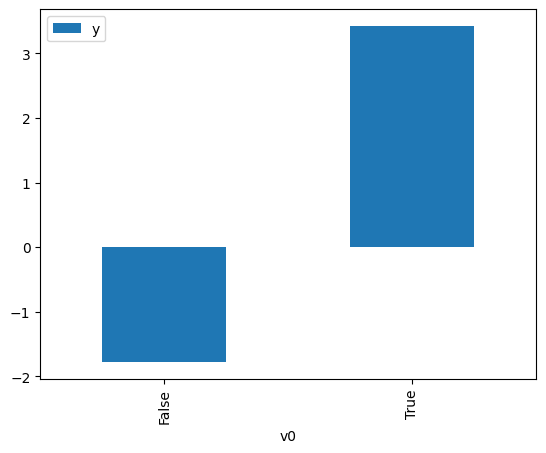

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

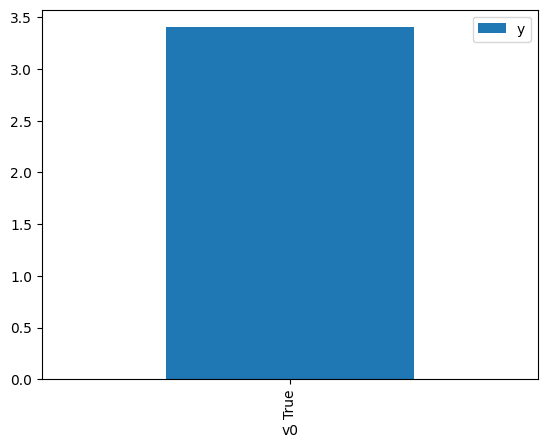

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.482072,False,-0.908054,0.729927,1.370001
1,0.013015,False,-0.730309,0.487222,2.052451
2,-1.278818,False,-4.620868,0.935630,1.068799
3,0.594899,False,-0.671086,0.217590,4.595789
4,0.237068,False,0.698818,0.371869,2.689119
...,...,...,...,...,...
995,-0.465994,False,-0.516214,0.723182,1.382777
996,0.039560,False,0.259734,0.473233,2.113124
997,-0.391814,False,-0.027024,0.690759,1.447682
998,0.222715,False,-0.712358,0.378975,2.638696


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.419088,True,-0.008668,0.006155,162.457794
1,0.335399,True,5.470800,0.675207,1.481027
2,-2.018438,True,0.715955,0.014227,70.288234
3,-2.018438,True,0.715955,0.014227,70.288234
4,0.603205,True,5.724675,0.785381,1.273268
...,...,...,...,...,...
995,-0.634181,True,4.161598,0.211580,4.726348
996,-0.150626,True,6.103703,0.426925,2.342329
997,-2.018438,True,0.715955,0.014227,70.288234
998,-0.949045,True,2.714001,0.121291,8.244635


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              8283.
Date:                Sat, 25 Oct 2025   Prob (F-statistic):                        0.00
Time:                        10:37:40   Log-Likelihood:                         -1393.8
No. Observations:                1000   AIC:                                      2792.
Df Residuals:                     998   BIC:                                      2801.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0553      0.025     83.644      0.000       2.007       2.104
x2             4.9876      0.056     88.282      0.000       4.877       5.098
==============================================================================
Omnibus:                        0.924   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.630   Jarque-Bera (JB):                0.969
Skew:                           0.072   Prob(JB):                        0.616
Kurtosis:                       2.950   Cond. No.                         2.32
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""